In [21]:
import torch
from torch import nn
from torchvision.models import resnet50
from transformers import DistilBertConfig, DistilBertModel, DistilBertTokenizer
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import albumentations as A

In [2]:
from CLIP import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CLIPModel(temperature=1.0, image_embedding=2048, text_embedding=768)
model.load_state_dict(torch.load('./CLIPModelDict.pt', map_location=device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [4]:
def make_train_valid_dfs(df):
    max_id = df['id'].max() + 1
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_df = df[df['id'].isin(train_ids)]
    train_df = train_df.drop(columns=['id'])
    valid_df = df[df['id'].isin(valid_ids)]
    valid_df = valid_df.drop(columns=['id'])
    return train_df, valid_df

In [6]:
captions_path = 'F:\Doby\CLIP\Flickr8k\captions.txt'

captions = pd.read_csv(captions_path, sep=',')
captions = captions.reset_index()
captions.rename(columns={'index': 'id'}, inplace=True)
train_df, valid_df = make_train_valid_dfs(captions)

In [7]:
def build_loaders(df, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        df['image'].values,
        df['caption'].values,
        tokenizer=tokenizer,
        transforms=transforms
    )
    dataloader = DataLoader(
        dataset,
        batch_size=8,
        num_workers=0,
        shuffle=True if mode == 'train' else False,
    )
    return dataloader

In [14]:
def get_image_embeddings(valid_df):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    valid_loader = build_loaders(valid_df, tokenizer, mode='valid')

    valid_image_embeddings = []
    model.eval()
    with torch.no_grad():
        n_data = 0
        for batch in valid_loader:
            image_features = model.image_encoder(batch['image'].to(device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
            n_data += 8
            print(f'\r{100.0*n_data/len(valid_loader.dataset):.2f}%', end='')
    return torch.cat(valid_image_embeddings)

In [15]:
image_embeddings = get_image_embeddings(valid_df)

100.06%

In [16]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
encoded_query = tokenizer(['Hello World'])
encoded_query

{'input_ids': [[101, 7592, 2088, 102]], 'attention_mask': [[1, 1, 1, 1]]}

In [49]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch['input_ids'], attention_mask=batch['attention_mask']
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    # Similarity 값이 높을수록 좋기 때문에 topk 함수를 통해 가장 높은 것 n*5개를 뽑는다.
    # 그리고, 그 중에 9개를 plt.show() 한다.
    values, indices = torch.topk(dot_similarity.squeeze(0), n*5)
    matches = [image_filenames[idx] for idx in indices[::5]]

    _, axes = plt.subplots(3, 3, figsize=(6, 6))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f'F:/Doby/CLIP/Flickr8k/Images/{match}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        ax.imshow(image)
        ax.axis('off')
    plt.suptitle(f'Query [{query}]')
    plt.show()

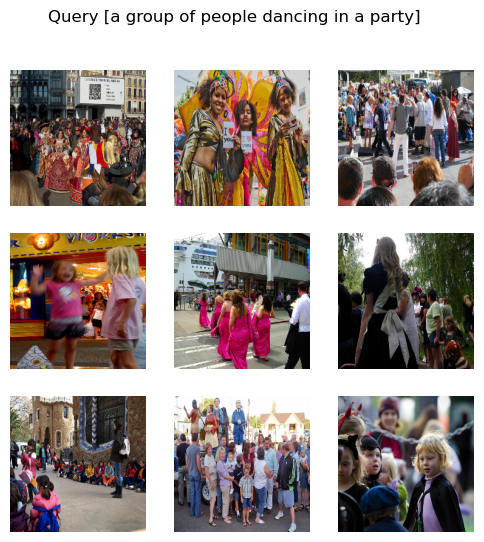

In [48]:
find_matches(
    model,
    image_embeddings,
    query = 'a group of people dancing in a party',
    image_filenames=valid_df['image'].values,
    n=9
)